In [13]:
import pandas as pd

# Remplacez 'nom_du_fichier.csv' par le chemin de votre fichier CSV
data = pd.read_csv("cities_africa.csv", sep = ";")
data_clean = data[['Name', 'Population', 'Coordinates']]  # Remplacez 'colonne1', 'colonne2', 'colonne3' par les noms de vos colonnes
nouvelles_colonnes = data['Coordinates'].str.split(',', expand=True)

# Renommer les nouvelles colonnes
nouvelles_colonnes.columns = ['lon', 'lat']

# Concaténer les nouvelles colonnes avec le DataFrame d'origine en supprimant la colonne d'origine
data_clean = pd.concat([data_clean, nouvelles_colonnes], axis=1).drop(columns=['Coordinates'])


import matplotlib.pyplot as plt
import numpy as np
import numba
from sklearn.cluster import KMeans


yp = data_clean["lon"] 
yp = np.array(yp)
yp = yp.astype(float)
xp = data_clean["lat"]  
xp = np.array(xp)
xp = xp.astype(float)
population = data_clean["Population"]
population = np.array(population)
population = population.astype(float)
population = np.random.randint(1, 501, size=len(xp))



P = np.vstack((xp, yp)).T


In [14]:
kmeans = KMeans(n_clusters=15, init = "k-means++", n_init = 100)
    #n_clusters = nombre de clusters avec lequel on travaille
    #init = méthode d'initialisation des centroides, "random" ça veut dire que les centroides sont placés en mode random et "k-means++" c'est une méthode qui donne des centroides optimisés
    #n_init = nombre de fois que l'algorithme va tourner et donner la meilleure solution


kmeans.fit(P,sample_weight = population)
y_kmeans = kmeans.predict(P, sample_weight = population)

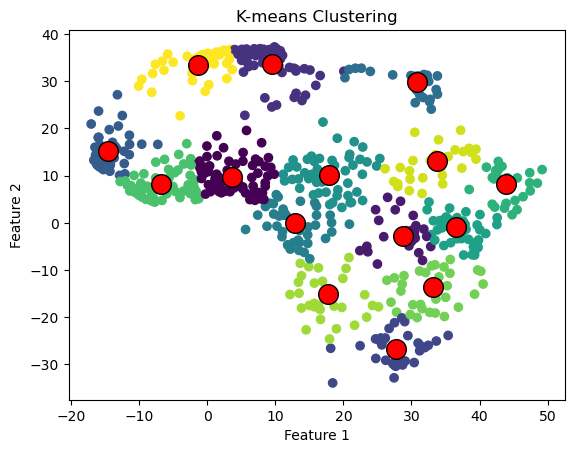

In [15]:
# Visualiser les clusters
plt.scatter(P[:, 0], P[:, 1], c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=200, edgecolor='k', c='red')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [16]:
my_centers = kmeans.cluster_centers_

print(my_centers)

[[  3.61484883   9.6614976 ]
 [ 28.79932837  -2.87575537]
 [  9.52883088  33.63212786]
 [ 27.73934048 -26.67605452]
 [-14.57048442  15.21724123]
 [ 30.78988279  29.85035295]
 [ 12.82084886  -0.09683708]
 [ 17.81997439  10.17824488]
 [ 36.56831006  -0.96734477]
 [ 43.82862687   8.25923111]
 [ -6.73884932   8.26643529]
 [ 33.19714141 -13.62327475]
 [ 17.71703463 -15.01886744]
 [ 33.80775502  13.17326682]
 [ -1.39838575  33.37147639]]


In [17]:
my_centers = my_centers.reshape(len(my_centers)*2,)


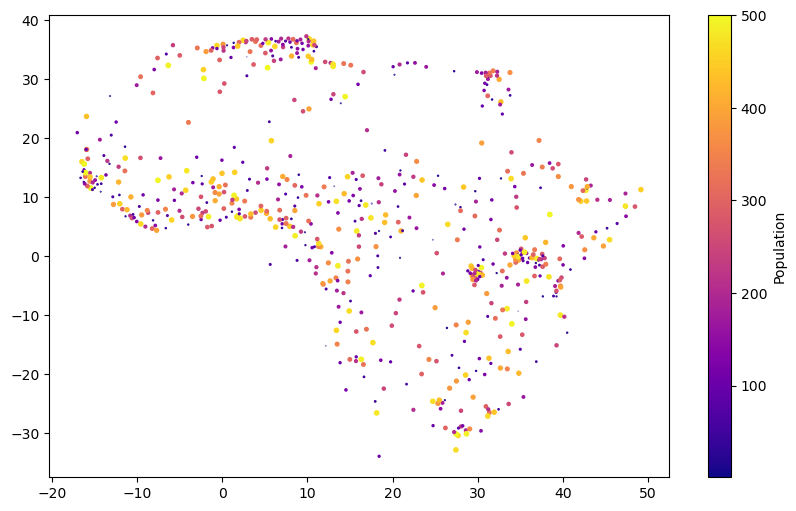

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)




# Déterminez la taille des points en fonction de la densité de population
# Vous pouvez ajuster le facteur multiplicatif selon vos préférences
size = population*0.02


# Affichage des densités de population en tant que points colorés
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size)
plt.colorbar(sc, label='Population')

In [19]:
Hs = 1
N = 10
Is = 10000
Imin = 1
IminSol = 1e-3
eps = 1e-1
p = 300


xt = np.linspace(-20, 50, 250)
yt = np.linspace(-40, 40, 250)
Xt, Yt = np.meshgrid(xt, yt)

In [20]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [21]:
@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(N) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)

def objectif(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq) * population[j]
            
        somme += sumj
        
    return -somme

@numba.jit(nopython = True, parallel = True)
def contrainte2(x) : 
    somme = 0
    for j in numba.prange(p) : 
        for k in numba.prange(p) : 
            sum_point = 0
            for i in numba.prange(N) : 
                x_posit = -20+(j/p)*70
                y_posit = -40+(k/p)*80
                di_sq = pyth(x_posit, x[2*i], y_posit, x[2*i+1]) + Hs**2

                sum_point += Is/(di_sq)
            if sum_point >= IminSol : 
                somme+=1
  
    return somme/(p**2)
    

In [22]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.8, 1)
#myc2 = NonlinearConstraint(contrainte2, 0.8, 1)
contraintes = [myc1]
x0 = my_centers

t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
#print("Valeur de la contrainte 2 : ", contrainte2(resultat.x))

temps :  33.51662611961365
 message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
 success: False
  status: 4
     fun: -307522361.6539826
       x: [ 1.135e+00  1.054e+01 ...  1.364e-01  3.545e+01]
    nfev: 1000
   maxcv: 0.003721698633724735
Résultat de l'optimisation: -307522361.6539826
Valeurs optimales des variables: [  1.13515434  10.53525018  28.95668274  -3.49486603   9.24365605
  34.44826167  27.55175952 -25.65493233 -15.64480056  14.62860092
  31.5423771   30.12146003  11.69326536   1.68400113  20.10611678
  10.32609811  35.52878404  -0.22073233  42.53851842  10.00210358
  -7.70638246   7.59401035  33.8041494  -11.36923695  17.31864051
 -14.77299798  33.86397148  13.23560837   0.13636329  35.45456474]
Valeur de la contrainte 1 :  0.7962783013662753


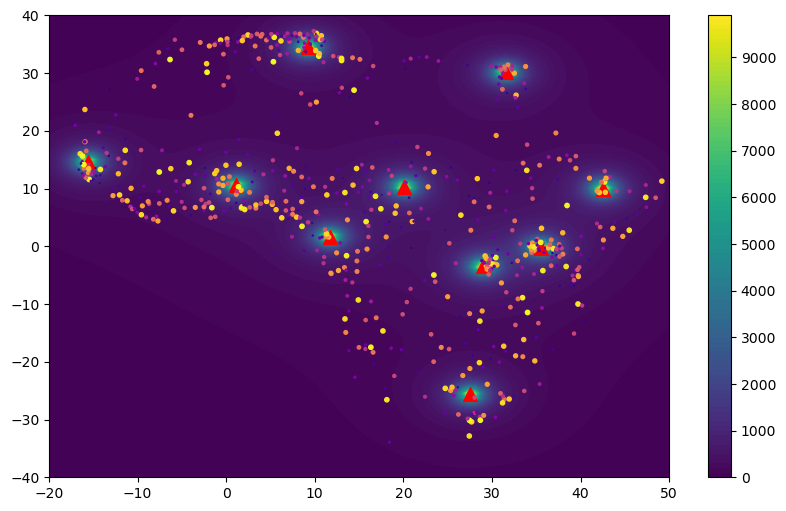

In [23]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(-20, 50, 100)
y = np.linspace(-40, 40, 100)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar(cf, ax = ax)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 100, label = "sattelites")
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)